In [81]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from tqdm import tqdm

from spring_rods_system_setup import SpringRodsSystemSetup
from spring_rods_system_solver import SpringRodsSystemSolver
from computational_utils import l2_norm

In [82]:
plt.rcParams.update({
    'axes.grid': True,
    'figure.facecolor': 'white',
    'mathtext.default': 'regular',
})

In [83]:
setup = {
    'interval': (-1, 1),
    'spring_len': 1,
    'material_const': (1, 1),
    'spring_const': (1, 1),
    'body_forces': lambda x: np.where(x < 0, 1, -1)
}

In [84]:
def approximate_in_positions(
        values: np.ndarray,
        reference_nodes: np.ndarray,
        nodes: np.ndarray
):
    assert reference_nodes.size == values.size
    result = np.empty_like(nodes)
    result[0] = result[-1] = 0
    ref_idx = 0
    for idx, curr_node in enumerate(nodes[1:-1], 1):
        while reference_nodes[ref_idx] <= curr_node and ref_idx < reference_nodes.size - 1:
            ref_idx += 1
        # print(f'{reference_nodes[ref_idx - 1]} <= {curr_node} < {reference_nodes[ref_idx]}')
        assert reference_nodes[ref_idx - 1] <= curr_node <= reference_nodes[ref_idx]
        delta = reference_nodes[ref_idx] - reference_nodes[ref_idx - 1]
        shift = curr_node - reference_nodes[ref_idx - 1]
        lin_diff = (values[ref_idx] - values[ref_idx - 1]) * shift / delta
        result[idx] = values[ref_idx - 1] + lin_diff
    return result

In [85]:
nodes_num_grid = [512, 256, 128, 64, 32, 16]

In [86]:
model = SpringRodsSystemSetup(
    **setup,
    nodes_num=1024
)

solver = SpringRodsSystemSolver(model)
solution = solver(model)

reference_domain = np.concatenate((model.domain[0], model.domain[1]))
reference_solution = solution.x

In [87]:
error = []

for idx, nodes_num in enumerate(tqdm(nodes_num_grid)):
    model = SpringRodsSystemSetup(
        **setup,
        nodes_num=nodes_num
    )

    solver = SpringRodsSystemSolver(model)
    solution = solver(model)

    curr_domain = np.concatenate((model.domain[0], model.domain[1]))
    solution_shifted = approximate_in_positions(solution.x, curr_domain, reference_domain)
    error.append(solution_shifted - reference_solution)

100%|██████████| 6/6 [01:32<00:00, 15.48s/it]


In [88]:
cmap = plt.get_cmap('tab10', len(nodes_num_grid))

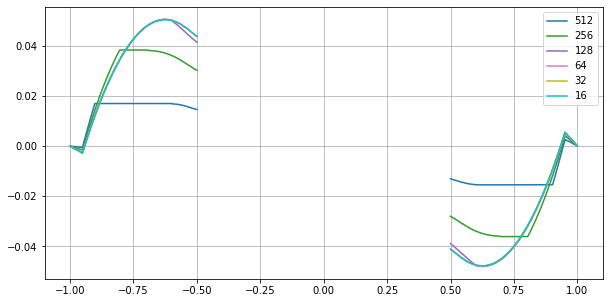

In [102]:
fig = plt.gcf()
fig.set_size_inches(10, 5)

for idx, err in enumerate(error):
    half = reference_domain.size // 2
    plt.plot(reference_domain[:half], err[:half], color=cmap(idx), label=f'{nodes_num_grid[idx]}')
    plt.plot(reference_domain[half:], err[half:], color=cmap(idx))

plt.legend()

In [103]:
norm_err = [l2_norm(err, reference_domain) for err in error]

Text(0, 0.5, '$||u - u^h||_{L^2}$')

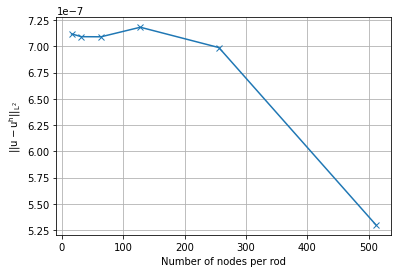

In [104]:
plt.plot(nodes_num_grid, norm_err, marker='x')
plt.xlabel('Number of nodes per rod')
plt.ylabel('$||u - u^h||_{L^2}$')
# plt.yscale('log')
# plt.xscale('log')

Text(0, 0.5, 'Mean absolute error')

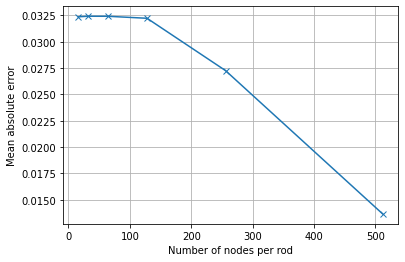

In [105]:
plt.plot(nodes_num_grid, np.average(np.abs(error), axis=1), marker='x')
plt.xlabel('Number of nodes per rod')
plt.ylabel('Mean absolute error')